In [1]:
cd ..

/home/mashraf/GCNs_for_WDS


In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
import torch
# torch.set_default_dtype(torch.float64) 
# torch.backends.cudnn.allow_tf32 = False
# torch.backends.cuda.matmul.allow_tf32 = False
import os, datetime
import numpy as np
from utils.utils import create_graph, WDN_Graph, plot_errors, plot_graph, plot_timeseries, normalize_hydraulics, denormalize_hydraulics
from models.models import *
from train_test import train, test
import argparse, json, pickle
import wandb
from collections import defaultdict
import warnings
import matplotlib.pyplot as plt
import pandas as pd
warnings.filterwarnings('ignore')
CUDA_LAUNCH_BLOCKING=1

In [9]:
wdss = ['anytown', 'hanoi', 'pescara', 'area_c', 'zhijiang', 'modena', 'pa1', 'balerma', 'area_a', 'l_town', 'kl']
args = argparse.Namespace()
s = 1000
attrib_df_list = []
for wds in wdss:
    scenario_path = os.path.join(os.getcwd(),"wds",  wds, 'toy', "s"+str(s))
    args.inp_file = os.path.join(scenario_path, wds+".inp")
    args.path_to_data = os.path.join(scenario_path, "results", "Measurements_All.xlsx")

    wdn_graph, reservoirs = create_graph(args.inp_file, args.path_to_data)


    attrib_dict = {}

    attrib_dict["WDS"] = wds
    attrib_dict["No. of junctions"] = wdn_graph.X.shape[1]
    attrib_dict["No. of links"] = wdn_graph.edge_attr.shape[1]//2
    attrib_dict["No. of reservoirs"] = len(reservoirs)

    G = nx.DiGraph()
    edge_list = [ (u, v) for u, v in zip(*np.array(wdn_graph.edge_index[0])) ]
    G.add_edges_from(edge_list)

    attrib_dict["Diameter"] = nx.diameter(G)
    node_degrees = [val for (node, val) in G.degree()]
    attrib_dict["Degree_min"] = np.round(np.min(node_degrees), 2)
    attrib_dict["Degree_mean"] = np.round(np.mean(node_degrees), 2)
    attrib_dict["Degree_max"] = np.round(np.max(node_degrees), 2)

    attrib_df = pd.DataFrame(attrib_dict, index=[wds])
    attrib_df_list.append(attrib_df)

attribs = pd.concat(attrib_df_list, ignore_index=True)
attribs.to_csv(os.path.join(os.getcwd(), "results_ijcnn", "wds_attributes.csv"))
display(attribs)


,WDS,No. of junctions,No. of links,No. of reservoirs,Diameter,Degree_min,Degree_mean,Degree_max
0,anytown,22,41,3,5,2,7.45,14
1,hanoi,32,34,1,13,2,4.25,8
2,pescara,71,99,3,20,2,5.52,10
3,area_c,93,109,1,20,2,4.69,8
4,zhijiang,114,164,1,24,2,5.75,8
5,modena,272,317,4,38,2,4.66,10
6,pa1,339,399,2,55,2,4.71,10
7,balerma,447,454,4,60,2,4.06,10
8,area_a,661,766,2,79,2,4.64,10
9,l_town,785,909,3,79,2,4.63,10


In [4]:
wdss = ['anytown', 'hanoi', 'pescara', 'area_c', 'zhijiang', 'modena', 'pa1', 'balerma', 'area_a', 'l_town', 'kl']
wds_names = ['Anytown', 'Hanoi', 'Pescara', 'Area C', 'Zhi Jiang', 'Modena', 'PA1', 'Balerma', 'Area A', 'L-Town', 'KL']

model = 'SPI_GNN'
_type = 'demands'

wntr_times, model_times = [], []
for wds in wdss:
    if _type == 'demands':
        csv_path = os.path.join(os.getcwd(), "results_ijcnn", model, "robustness", "robustness_"+wds+"_"+model+"_[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ].csv")
    elif _type == 'diameters':
        csv_path = os.path.join(os.getcwd(), "results_ijcnn", model, "robustness", "robustness_"+wds+"_"+model+"_[0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 ].csv")

    robust_df = pd.read_csv(csv_path).T
    robust_df.columns = robust_df.iloc[0]
    robust_df = robust_df.drop(robust_df.index[0]).astype('float32')

    sigmas = robust_df["sigma"].values * 10
    wntr_time = robust_df["wntr_times"].values 
    model_time = robust_df["model_times"].values 

    wntr_times.append(wntr_time)
    model_times.append(model_time)


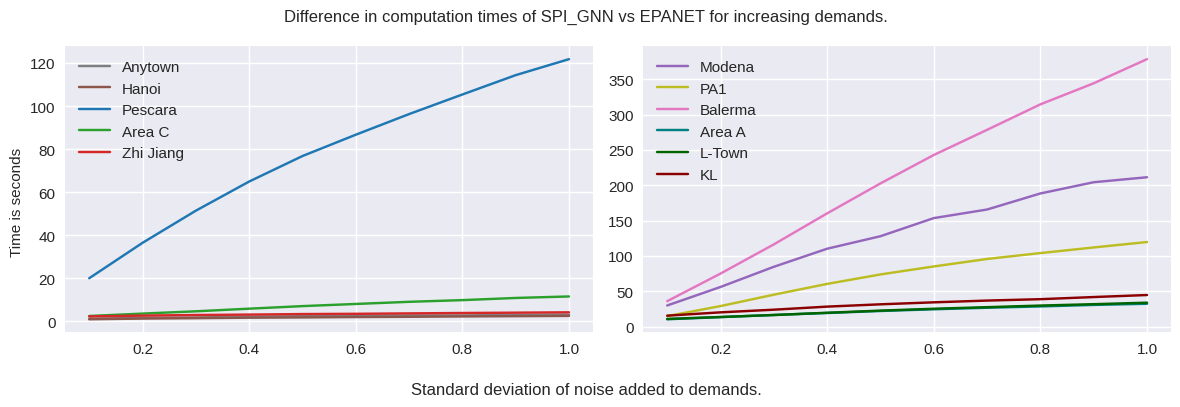

In [10]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams["font.family"] = "Times New Roman"

colors = ['tab:gray', 'tab:brown', 'tab:blue', 'tab:green', 'tab:red', 'tab:purple', 'tab:olive', 'tab:pink', 'teal', 'darkgreen', 'darkred']

plt.style.use('seaborn-v0_8')

fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True, tight_layout=True)

for idx in range(len(wdss)-6):
    ax[0].plot(sigmas, wntr_times[idx] - model_times[idx], label=wds_names[idx], color=colors[idx])
ax[0].tick_params(labelsize=11)
ax[0].legend(fontsize=11, loc='upper left')


for idx in range(5,len(wdss)):
    ax[1].plot(sigmas, wntr_times[idx] - model_times[idx], label=wds_names[idx], color=colors[idx])
ax[1].tick_params(labelsize=11)
ax[1].legend(fontsize=11, loc='upper left')

fig.supxlabel('Standard deviation of noise added to '+_type+'.', size=12)
fig.supylabel('Time is seconds', size=11)
fig.suptitle('Difference in computation times of SPI_GNN vs EPANET for increasing '+_type+'.', size=12)
fig.savefig(os.path.join(os.getcwd(), 'results_ijcnn', 'time_plot_'+_type+'.jpg'), dpi=300)
# plt.close()


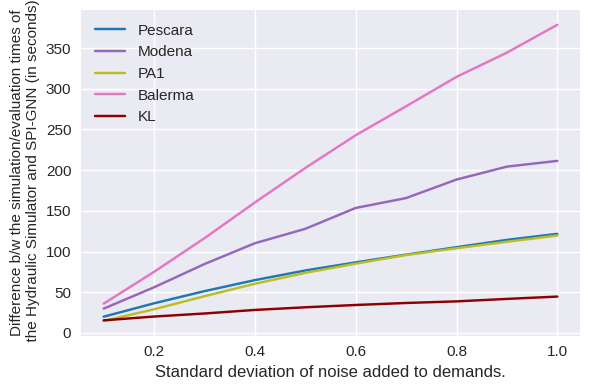

In [22]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams["font.family"] = "Times New Roman"

plt.style.use('seaborn-v0_8')

wdss_idx = [2, 5, 6, 7, 10]
colors = ['tab:gray', 'tab:brown', 'tab:blue', 'tab:green', 'tab:red', 'tab:purple', 'tab:olive', 'tab:pink', 'teal', 'darkgreen', 'darkred']

fig, ax = plt.subplots(1, 1, figsize=(6, 4), sharex=True, tight_layout=True)

for idx in wdss_idx:
    ax.plot(sigmas, wntr_times[idx] - model_times[idx], label=wds_names[idx], color=colors[idx])
ax.tick_params(labelsize=11)
ax.legend(fontsize=11, loc='upper left')

ax.set_xlabel('Standard deviation of noise added to '+_type+'.', size=12)
ax.set_ylabel('Difference b/w the simulation/evaluation times of\n  the Hydraulic Simulator and SPI-GNN (in seconds).', size=11)
# fig.suptitle('Difference in computation times of SPI_GNN vs EPANET for increasing '+_type+'.', size=12)
fig.savefig(os.path.join(os.getcwd(), 'results_ijcnn', 'time_plot_'+_type+'_single.jpg'), dpi=300)
# plt.close()


In [40]:

wds_names_5 = ['Pescara', 'Modena', 'PA1', 'Balerma', 'KL']

wntr_times_df = pd.DataFrame(np.stack(wntr_times).T, columns=wds_names)
wntr_times_df_5 = wntr_times_df[wds_names_5]
wntr_times_df_5

,Pescara,Modena,PA1,Balerma,KL
0,20.722431,31.694860,17.429268,38.923538,23.632502
1,36.965176,57.807026,31.692604,77.952713,28.376566
2,51.913654,86.391914,47.792072,119.326401,32.230965
3,65.475494,111.983124,63.135025,163.218658,36.605667
4,77.308174,129.703796,76.542320,205.627106,39.927063
5,87.289703,155.382538,87.864792,245.869354,42.786369
6,96.827164,167.521439,98.514198,281.481476,45.254932
7,105.920708,190.274323,106.823227,317.583984,47.292221
8,114.912659,206.172455,114.806999,347.433319,50.307087
9,122.347160,213.215454,122.497940,381.586700,53.237171


In [41]:
model_times_df = pd.DataFrame(np.stack(model_times).T, columns=wds_names)
model_times_df_5 = model_times_df[wds_names_5]
model_times_df_5

,Pescara,Modena,PA1,Balerma,KL
0,0.753395,1.821663,2.651689,2.947191,8.159523
1,0.547911,1.710145,2.672488,2.892074,8.223511
2,0.553944,1.750806,2.636798,2.952362,8.321029
3,0.572918,1.750126,2.723465,2.933064,8.342455
4,0.559874,1.778346,2.721014,2.945710,8.406974
5,0.630605,1.812858,2.742292,2.968521,8.443477
6,0.579976,1.797563,2.789220,2.969585,8.435211
7,0.569266,1.810473,2.757027,2.977944,8.501944
8,0.568918,1.816241,2.791287,3.005655,8.496897
9,0.570771,1.819399,2.793176,2.994950,8.546099


In [45]:
speedup_df = 100 * ((wntr_times_df_5 - model_times_df_5).abs() / model_times_df_5)
speedup_df.round(0)

,Pescara,Modena,PA1,Balerma,KL
0,2651.0,1640.0,557.0,1221.0,190.0
1,6647.0,3280.0,1086.0,2595.0,245.0
2,9272.0,4834.0,1713.0,3942.0,287.0
3,11328.0,6299.0,2218.0,5465.0,339.0
4,13708.0,7194.0,2713.0,6881.0,375.0
5,13742.0,8471.0,3104.0,8183.0,407.0
6,16595.0,9219.0,3432.0,9379.0,437.0
7,18507.0,10410.0,3775.0,10565.0,456.0
8,20098.0,11252.0,4013.0,11459.0,492.0
9,21335.0,11619.0,4286.0,12641.0,523.0


In [46]:
speedup_df = 100 * ((wntr_times_df - model_times_df).abs() / model_times_df)
speedup_df.round(0)

,Anytown,Hanoi,Pescara,Area C,Zhi Jiang,Modena,PA1,Balerma,Area A,L-Town,KL
0,301.0,242.0,2651.0,332.0,239.0,1640.0,557.0,1221.0,173.0,151.0,190.0
1,504.0,390.0,6647.0,535.0,297.0,3280.0,1086.0,2595.0,227.0,188.0,245.0
2,406.0,457.0,9272.0,662.0,327.0,4834.0,1713.0,3942.0,278.0,224.0,287.0
3,670.0,497.0,11328.0,829.0,346.0,6299.0,2218.0,5465.0,322.0,263.0,339.0
4,732.0,507.0,13708.0,1012.0,368.0,7194.0,2713.0,6881.0,369.0,303.0,375.0
5,776.0,556.0,13742.0,1147.0,381.0,8471.0,3104.0,8183.0,407.0,336.0,407.0
6,837.0,569.0,16595.0,1285.0,414.0,9219.0,3432.0,9379.0,442.0,364.0,437.0
7,604.0,638.0,18507.0,1394.0,435.0,10410.0,3775.0,10565.0,471.0,394.0,456.0
8,925.0,697.0,20098.0,1545.0,451.0,11252.0,4013.0,11459.0,504.0,419.0,492.0
9,957.0,709.0,21335.0,1592.0,470.0,11619.0,4286.0,12641.0,529.0,446.0,523.0
